In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

from sqlalchemy import create_engine
import requests
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
RANDOM_STATE = 42
ORIG_DATA_PATH = Path('../orig_data')
DATA_PATH = Path('../data')

In [4]:
plt.rcParams['figure.figsize'] = (8, 6)

# Data Understanding

## Collect initial data

### Original data

In [5]:
if not ORIG_DATA_PATH.exists():
    ORIG_DATA_PATH.mkdir(exist_ok=True)

In [6]:
urls = ['https://datasets.figure-eight.com/figure_eight_datasets/disaster_response_data/disaster_response_messages_training.csv',
        'https://datasets.figure-eight.com/figure_eight_datasets/disaster_response_data/disaster_response_messages_test.csv',
        'https://datasets.figure-eight.com/figure_eight_datasets/disaster_response_data/disaster_response_messages_validation.csv']

file_paths = [ORIG_DATA_PATH/'train_df.csv', 
              ORIG_DATA_PATH/'test_df.csv',
              ORIG_DATA_PATH/'valid_df.csv']

def download_file(url, file_path):
    if not file_path.exists():
        r = requests.get(url)

        with open(file_path, 'w') as f:
            f.write(r.text[3:])
        
for url, file_path in tqdm(zip(urls, file_paths)):
    download_file(url, file_path)

3it [00:00, 5414.33it/s]


In [7]:
dfs = []

for file_path in tqdm(file_paths):
    dfs.append(pd.read_csv(file_path, low_memory=False))
    
full_df = pd.concat(dfs, axis=0)
full_df = full_df.drop('PII', axis=1)
print(full_df.shape)
full_df.head()

100%|██████████| 3/3 [00:00<00:00, 17.18it/s]


(26248, 41)


,id,split,message,original,genre,related,request,offer,aid_related,medical_help,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,train,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,train,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,...,0,0,1,0,1,0,0,0,0,0
2,12,train,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14,train,Information about the National Palace-,Informtion au nivaux palais nationl,direct,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,15,train,Storm at sacred heart of jesus,Cyclone Coeur sacr de jesus,direct,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0


### Project data

In [8]:
messages_df = pd.read_csv(DATA_PATH/'disaster_messages.csv')
messages_df.head()

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct


In [9]:
categories_df = pd.read_csv(DATA_PATH/'disaster_categories.csv')
categories_df.head()

,id,categories
0,2,related-1;request-0;offer-0;aid_related-0;medi...
1,7,related-1;request-0;offer-0;aid_related-1;medi...
2,8,related-1;request-0;offer-0;aid_related-0;medi...
3,9,related-1;request-1;offer-0;aid_related-1;medi...
4,12,related-1;request-0;offer-0;aid_related-0;medi...


## Describe data

### Original data

In [10]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26248 entries, 0 to 2572
Data columns (total 41 columns):
id                        26248 non-null int64
split                     26248 non-null object
message                   26248 non-null object
original                  10184 non-null object
genre                     26248 non-null object
related                   26248 non-null int64
request                   26248 non-null int64
offer                     26248 non-null int64
aid_related               26248 non-null int64
medical_help              26248 non-null int64
medical_products          26248 non-null int64
search_and_rescue         26248 non-null int64
security                  26248 non-null int64
military                  26248 non-null int64
child_alone               26248 non-null int64
water                     26248 non-null int64
food                      26248 non-null int64
shelter                   26248 non-null int64
clothing                  26248 non-null i

In [11]:
full_df.loc[:, 'related':].apply(pd.value_counts).T

,0,1,2
related,6125.0,19930.0,193.0
request,21768.0,4480.0,NaN
offer,26129.0,119.0,NaN
aid_related,15370.0,10878.0,NaN
medical_help,24161.0,2087.0,NaN
medical_products,24934.0,1314.0,NaN
search_and_rescue,25524.0,724.0,NaN
security,25777.0,471.0,NaN
military,25388.0,860.0,NaN
child_alone,26248.0,NaN,NaN


In [12]:
full_df.duplicated(keep=False).sum()

63

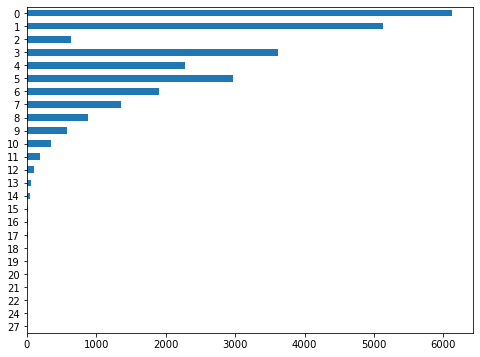

In [13]:
full_df.loc[:, 'related':].sum(axis=1).value_counts().sort_index(ascending=False).plot.barh()

### Project data

**Messages**

In [14]:
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26248 entries, 0 to 26247
Data columns (total 4 columns):
id          26248 non-null int64
message     26248 non-null object
original    10184 non-null object
genre       26248 non-null object
dtypes: int64(1), object(3)
memory usage: 820.4+ KB


In [15]:
messages_df.describe(include='all')

,id,message,original,genre
count,26248.000000,26248,10184,26248
unique,NaN,26177,9630,3
top,NaN,#NAME?,Nap fe ou konnen ke apati de jodi a sevis SMS ...,news
freq,NaN,4,20,13068
mean,15224.078368,NaN,NaN,NaN
std,8826.069156,NaN,NaN,NaN
min,2.000000,NaN,NaN,NaN
25%,7445.750000,NaN,NaN,NaN
50%,15660.500000,NaN,NaN,NaN
75%,22923.250000,NaN,NaN,NaN


In [16]:
messages_df.duplicated(keep=False).sum()

135

**Categories**

In [17]:
categories_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26248 entries, 0 to 26247
Data columns (total 2 columns):
id            26248 non-null int64
categories    26248 non-null object
dtypes: int64(1), object(1)
memory usage: 410.2+ KB


In [18]:
categories_df.duplicated(keep=False).sum()

63

In [19]:
categories_df.describe(include='all')

,id,categories
count,26248.000000,26248
unique,NaN,4003
top,NaN,related-0;request-0;offer-0;aid_related-0;medi...
freq,NaN,6125
mean,15224.078368,NaN
std,8826.069156,NaN
min,2.000000,NaN
25%,7445.750000,NaN
50%,15660.500000,NaN
75%,22923.250000,NaN


## Explore data

### Messages

**id**

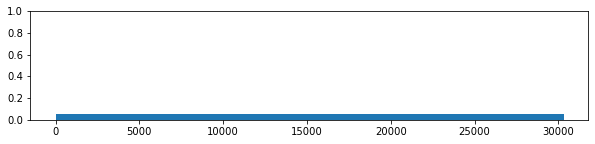

In [20]:
plt.figure(figsize=(10, 2))
sns.rugplot(messages_df['id'])

**message**

In [21]:
messages_df['message'].value_counts(dropna=False).head()

#NAME?                                                                                                                                                                                   4
Shelter materials (thick polyesters) are being distributed to 18,000 households.                                                                                                         3
I thought you gave my number and this was serious. Meanwhile today has been 15 days and we still haven't gotten anything                                                                 2
What can i do to protect my self if the earthquake comes back?                                                                                                                           2
The Management Committee is composed of six members, including a chairman, a treasurer, a secretary general, a manager and two commissioners elected democratically by the community.    2
Name: message, dtype: int64

In [22]:
messages_df['message'].str.len().describe()

count    26248.000000
mean       144.754267
std        207.170242
min          4.000000
25%         75.000000
50%        124.000000
75%        179.000000
max      10818.000000
Name: message, dtype: float64

In [23]:
messages_df[messages_df['message'].str.len() < 30]

,id,message,original,genre
351,425,"Need food, water and medicine","Nous avons besoin des tentes, de la nourriture...",direct
1473,1721,sports information. football.,informations sportives. football,direct
1571,1827,I'm a chauffeur. I need work.,Mwen se yon chof mwen bezwen travay,direct
2528,2913,"I miss you terribly, my dear.",Tu me manques normement chouchou!,direct
2954,3406,I would like to get info. ..,Je voudrais avoir des infos. ..,direct
3787,4340,"I live in Belaire, I need ..",mwen rete belaire mwen bezwen. .. ..,direct
6797,7700,paklascencion##s,Paklascencion##s,direct
7141,8057,9GeQYeYGQEQtm,9GeQYeYGQEQtmi,direct
7266,8192,0H 8@@ @2x @e8x3 xr,0Hlt 8@@ @2x @e8x3 xr a,direct
7559,8497,//// // @:@,//// // @lt : gt@,direct


**original**

In [24]:
messages_df['original'].str.len().describe()

count    10184.000000
mean        85.360369
std         45.029406
min          1.000000
25%         49.000000
50%         70.000000
75%        119.000000
max        327.000000
Name: original, dtype: float64

In [25]:
messages_df['original'].value_counts(dropna=False).head()

NaN                                                                                                                                                          16064
Nap fe ou konnen ke apati de jodi a sevis SMS 4636 pou enfomasyon ijan                                                                                          20
Un front froid se retrouve sur Cuba ce matin. Il pourrait traverser Haiti demain. Des averses de pluie isolee sont encore prevues sur notre region ce soi       19
4636 : Nasyonzini di ou men m retire kounye a tout fatra ak gravwa nan#                                                                                          7
Enfomasyon sou tranbleman ta a                                                                                                                                   6
Name: original, dtype: int64

**genre**

In [26]:
messages_df['genre'].value_counts(dropna=False)

news      13068
direct    10782
social     2398
Name: genre, dtype: int64

In [27]:
messages_df.groupby([messages_df['original'].isnull(), 'genre'])['id'].count()

original  genre 
False     direct    10184
True      direct      598
          news      13068
          social     2398
Name: id, dtype: int64

### Categories

**id**

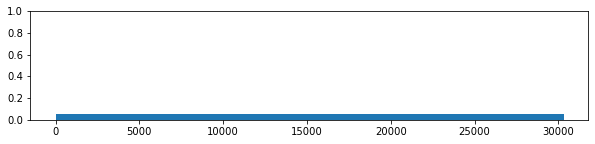

In [28]:
plt.figure(figsize=(10, 2))
sns.rugplot(categories_df['id'])

**categories**

In [29]:
categories_df['categories'].value_counts(dropna=False).head()

related-0;request-0;offer-0;aid_related-0;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-0;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-0;floods-0;storm-0;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0    6125
related-1;request-0;offer-0;aid_related-0;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-0;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-0;floods-0;storm-0;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0    5123
related-1;request-0;offer-0;aid_related-0;medical_help-0;medical_products-0;search_and_rescu

# Data Preparation

## Select data

### Messages

In [30]:
clean_messages_df = messages_df.drop_duplicates()
clean_messages_df = clean_messages_df[['id', 'message']]
clean_messages_df

,id,message
0,2,Weather update - a cold front from Cuba that c...
1,7,Is the Hurricane over or is it not over
2,8,Looking for someone but no name
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...
4,12,"says: west side of Haiti, rest of the country ..."
...,...,...
26243,30261,The training demonstrated how to enhance micro...
26244,30262,A suitable candidate has been selected and OCH...
26245,30263,"Proshika, operating in Cox's Bazar municipalit..."
26246,30264,"Some 2,000 women protesting against the conduc..."


### Categories

In [31]:
clean_categories_df = categories_df.drop_duplicates()
clean_categories_df = clean_categories_df[['id', 'categories']]
clean_categories_df.head()

,id,categories
0,2,related-1;request-0;offer-0;aid_related-0;medi...
1,7,related-1;request-0;offer-0;aid_related-1;medi...
2,8,related-1;request-0;offer-0;aid_related-0;medi...
3,9,related-1;request-1;offer-0;aid_related-1;medi...
4,12,related-1;request-0;offer-0;aid_related-0;medi...


## Clean data

### Messages

### Categories

In [32]:
parsed_categories = clean_categories_df['categories'].str.split(';|-')
parsed_categories_df = parsed_categories.str[1::2].apply(pd.Series)
parsed_categories_df = parsed_categories_df.astype('int8')
parsed_categories_df.columns = parsed_categories.str[0::2].iloc[0]
parsed_categories_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26216 entries, 0 to 26247
Data columns (total 36 columns):
related                   26216 non-null int8
request                   26216 non-null int8
offer                     26216 non-null int8
aid_related               26216 non-null int8
medical_help              26216 non-null int8
medical_products          26216 non-null int8
search_and_rescue         26216 non-null int8
security                  26216 non-null int8
military                  26216 non-null int8
child_alone               26216 non-null int8
water                     26216 non-null int8
food                      26216 non-null int8
shelter                   26216 non-null int8
clothing                  26216 non-null int8
money                     26216 non-null int8
missing_people            26216 non-null int8
refugees                  26216 non-null int8
death                     26216 non-null int8
other_aid                 26216 non-null int8
infrastructure_re

In [33]:
clean_categories_df = clean_categories_df.drop('categories', axis=1)
clean_categories_df = pd.concat([clean_categories_df, parsed_categories_df], axis=1)
clean_categories_df.loc[:, 'related':].apply(pd.value_counts).T

,0,1,2
related,6122.0,19906.0,188.0
request,21742.0,4474.0,NaN
offer,26098.0,118.0,NaN
aid_related,15356.0,10860.0,NaN
medical_help,24132.0,2084.0,NaN
medical_products,24903.0,1313.0,NaN
search_and_rescue,25492.0,724.0,NaN
security,25745.0,471.0,NaN
military,25356.0,860.0,NaN
child_alone,26216.0,NaN,NaN


In [34]:
related_map = {0: 0, 1: 1, 2: 0}

clean_categories_df = clean_categories_df.drop('child_alone', axis=1)
clean_categories_df['related'] = clean_categories_df['related'].map(related_map).astype('int8')
clean_categories_df.loc[:, 'related':].apply(pd.value_counts).T

,0,1
related,6310,19906
request,21742,4474
offer,26098,118
aid_related,15356,10860
medical_help,24132,2084
medical_products,24903,1313
search_and_rescue,25492,724
security,25745,471
military,25356,860
water,24544,1672


## Integrate data

In [35]:
clean_df = clean_messages_df.merge(clean_categories_df, how='inner', on='id')
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26216 entries, 0 to 26215
Data columns (total 37 columns):
id                        26216 non-null int64
message                   26216 non-null object
related                   26216 non-null int8
request                   26216 non-null int8
offer                     26216 non-null int8
aid_related               26216 non-null int8
medical_help              26216 non-null int8
medical_products          26216 non-null int8
search_and_rescue         26216 non-null int8
security                  26216 non-null int8
military                  26216 non-null int8
water                     26216 non-null int8
food                      26216 non-null int8
shelter                   26216 non-null int8
clothing                  26216 non-null int8
money                     26216 non-null int8
missing_people            26216 non-null int8
refugees                  26216 non-null int8
death                     26216 non-null int8
other_aid     

# Data Understanding

## Explore data

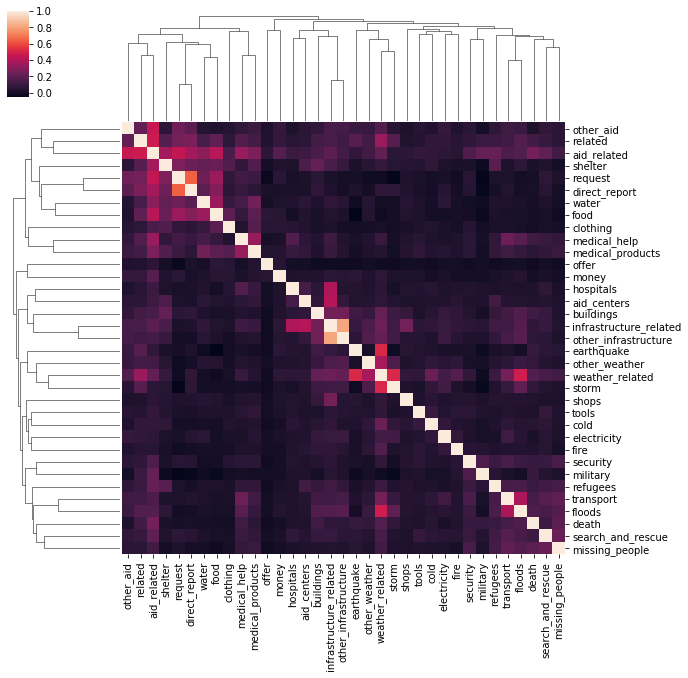

In [36]:
sns.clustermap(clean_df.loc[:, 'related':'direct_report'].corr())

In [37]:
clean_df.groupby('related').apply(lambda x: x.loc[:, 'request':].sum()).sum(axis=1)

related
0        0
1    63041
dtype: int64

In [38]:
clean_df.groupby(['other_aid', 'related', 'aid_related'])['id'].count()

other_aid  related  aid_related
0          0        0              6310
           1        0              9046
                    1              7414
1          1        1              3446
Name: id, dtype: int64

In [39]:
clean_df.groupby(['request', 'direct_report'])['id'].count()

request  direct_report
0        0                20058
         1                 1684
1        0                 1083
         1                 3391
Name: id, dtype: int64

In [40]:
clean_df.groupby(['medical_help', 'medical_products', 'aid_related'])['id'].count()

medical_help  medical_products  aid_related
0             0                 0              15356
                                1               8095
              1                 1                681
1             0                 1               1452
              1                 1                632
Name: id, dtype: int64

In [41]:
clean_df.groupby(['hospitals', 'aid_centers', 'infrastructure_related'])['id'].count()

hospitals  aid_centers  infrastructure_related
0          0            0                         24511
                        1                          1156
           1            1                           266
1          0            1                           240
           1            1                            43
Name: id, dtype: int64

In [42]:
clean_df.groupby(['infrastructure_related', 'other_infrastructure'])['id'].count()

infrastructure_related  other_infrastructure
0                       0                       24511
1                       0                         554
                        1                        1151
Name: id, dtype: int64

In [43]:
clean_df.groupby(['other_weather', 'weather_related'])['id'].count()

other_weather  weather_related
0              0                  18919
               1                   5921
1              1                   1376
Name: id, dtype: int64

In [44]:
clean_df.groupby(['transport', 'floods'])['id'].count()

transport  floods
0          0         23557
           1          1458
1          0           504
           1           697
Name: id, dtype: int64

**Rules**
- child_alone = 0
- related = 0 => all another classes == 0
- other_aid = 1 => related = 1, aid_related = 1
- medical_products = 1 => aid_related = 1
- aid_centers = 1 => infrastructure_related = 1
- infrastructure_related = 0 => other_infrastructure = 0
- other_weather = 1 => weather_related = 1

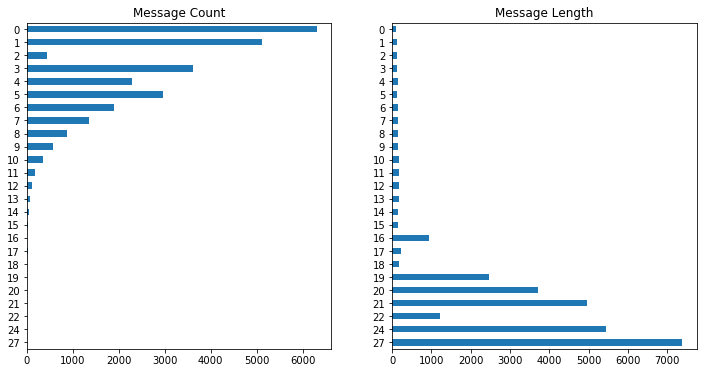

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

class_count = clean_df.loc[:, 'related':'direct_report'].sum(axis=1)

axes[0].set_title('Message Count')
clean_df.groupby(class_count)['message'].count().sort_index(ascending=False).plot.barh(ax=axes[0])

axes[1].set_title('Message Length')
clean_df.groupby(class_count)['message'].apply(lambda x: x.str.len().median()).sort_index(ascending=False).plot.barh(ax=axes[1])

In [46]:
class_count.describe()

count    26216.000000
mean         3.163984
std          2.989600
min          0.000000
25%          1.000000
50%          3.000000
75%          5.000000
max         27.000000
dtype: float64

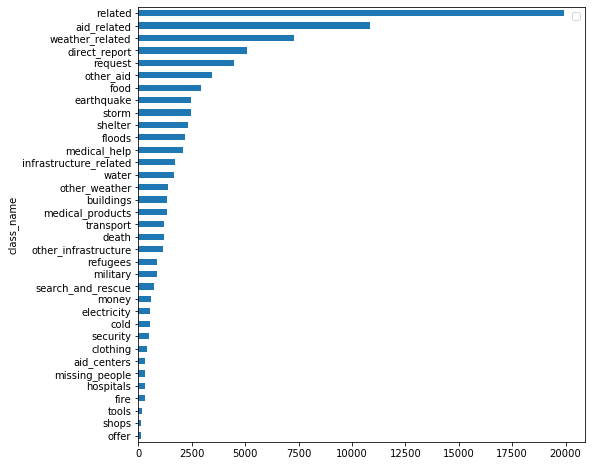

In [47]:
melted_classes_df = pd.melt(clean_df.loc[:, 'related':'direct_report'], var_name='class_name')
melted_classes_df.groupby('class_name').sum().sort_values('value', ascending=True).astype('int').plot.barh(figsize=(8, 8))
plt.legend('')

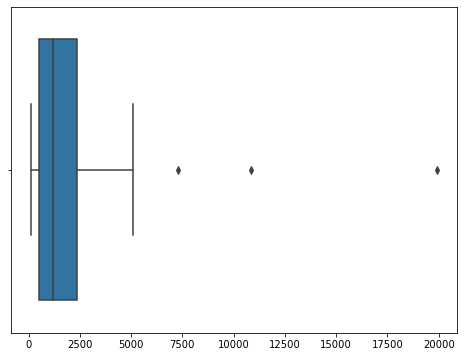

In [48]:
sns.boxplot(melted_classes_df.groupby('class_name').sum().sort_values('value', ascending=True))

In [49]:
clean_df.loc[:, 'related':'direct_report'].astype('str').apply(lambda x: ''.join(x), axis=1).nunique()

4002

# Data Preparation

## Construct data

In [52]:
clean_df['message_len'] = clean_df['message'].str.len()

# Modeling

In [64]:
from scipy import stats

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler, LabelEncoder

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, accuracy_score, hamming_loss, make_scorer, jaccard_score

from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

In [54]:
from functools import partial, update_wrapper

def wrapped_partial(func, *args, **kwargs):
    partial_func = partial(func, *args, **kwargs)
    update_wrapper(partial_func, func)
    return partial_func

In [55]:
X = clean_df
Y = clean_df.loc[:, 'related':'direct_report']
X.shape, Y.shape

((26216, 38), (26216, 35))

In [56]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=RANDOM_STATE)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((20972, 38), (5244, 38), (20972, 35), (5244, 35))

In [57]:
Y_train_props = Y_train.apply(pd.value_counts, normalize=True)
print(Y_train_props.min().min())
Y_train_props

0.004386801449551783


,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,0.238604,0.829344,0.995613,0.583778,0.920751,0.950267,0.971533,0.981738,0.966384,0.936439,...,0.988461,0.955751,0.720628,0.916842,0.906685,0.989081,0.905731,0.980307,0.947549,0.806695
1,0.761396,0.170656,0.004387,0.416222,0.079249,0.049733,0.028467,0.018262,0.033616,0.063561,...,0.011539,0.044249,0.279372,0.083158,0.093315,0.010919,0.094269,0.019693,0.052451,0.193305


In [58]:
Y_test_props = Y_test.apply(pd.value_counts, normalize=True)
print(Y_test_props.min().min())
Y_test_props

0.004195270785659802


,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,0.249047,0.829329,0.995042,0.593631,0.919527,0.948513,0.975782,0.983219,0.970442,0.935355,...,0.987223,0.957475,0.725782,0.921625,0.907323,0.989893,0.908848,0.977689,0.947368,0.805301
1,0.750953,0.170671,0.004958,0.406369,0.080473,0.051487,0.024218,0.016781,0.029558,0.064645,...,0.012777,0.042525,0.274218,0.078375,0.092677,0.010107,0.091152,0.022311,0.052632,0.194699


In [59]:
Y_props_diff = np.abs(Y_train_props - Y_test_props)
Y_props_diff.max().max()

0.010442676610839863

In [60]:
text_col = 'message'
text_pipe = Pipeline([
    ('tfidf', TfidfVectorizer())
])

num_cols = ['message_len']
num_pipe = Pipeline([
    ('scale', PowerTransformer())
])

preproc_pipe = ColumnTransformer([
    ('text', text_pipe, text_col),
#     ('num', num_pipe, num_cols),
], n_jobs=-1)

pipe = Pipeline([
    ('preprocess', preproc_pipe),
    ('clf', DummyClassifier())
])

In [61]:
preproc_pipe.fit_transform(X_train)

<20972x31026 sparse matrix of type '<class 'numpy.float64'>'
	with 428204 stored elements in Compressed Sparse Row format>

In [62]:
average = 'samples'
scoring = {
    'f1': make_scorer(wrapped_partial(f1_score, average=average)),
    'precision': make_scorer(wrapped_partial(precision_score, average=average)),
    'recall': make_scorer(wrapped_partial(recall_score, average=average)),
    'accuracy': make_scorer(accuracy_score),
    'hamming_loss': make_scorer(hamming_loss),
    'jaccard': make_scorer(jaccard_score, average=average)
}

In [61]:
refit = 'f1'

clfs_list = [
    LogisticRegression(random_state=RANDOM_STATE, solver='lbfgs'),
    LinearSVC(random_state=RANDOM_STATE),
    MultinomialNB(),
    
#     GradientBoostingClassifier(random_state=RANDOM_STATE),
#     HistGradientBoostingClassifier(random_state=RANDOM_STATE),
#     SVC(random_state=RANDOM_STATE)
]

multi_clfs_list = [
    DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE),
    RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    ExtraTreesClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    
#     KNeighborsClassifier(n_jobs=-1),
]

all_clfs_list = clfs_list #+ multi_clfs_list

param_grid = [
    {
        'clf': [MultiOutputClassifier(DummyClassifier(), n_jobs=-1)],
        'clf__estimator': all_clfs_list
    },
    {
        'clf': [ClassifierChain(DummyClassifier(), order='random', random_state=RANDOM_STATE)],
        'clf__base_estimator': all_clfs_list
    },
#     {
#         'clf': multi_clfs_list
#     },
#     {
#         'clf': [OneVsRestClassifier(DummyClassifier(), n_jobs=-1)],
#         'clf__estimator': clfs_list
#     },
]

cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
grid_search = GridSearchCV(pipe, param_grid, scoring=scoring, refit=refit,
                                 cv=cv, verbose=2, n_jobs=-1)
grid_search.fit(X_train, Y_train)
grid_search.best_score_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:   22.8s remaining:    8.8s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   33.9s finished


0.5085011024361784

In [62]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_results_df = cv_results_df.filter(regex=f'param_clf|mean_test|rank_test_{refit}')
cv_results_df['param_clf'] = cv_results_df['param_clf'].astype('str').str.split('(').str[0]
cv_results_df = cv_results_df.sort_values(f'rank_test_{refit}')

if (cv_results_df.filter(like='estimator').shape[1] == 2):
    cv_results_df.insert(1, 'estimator', np.where(cv_results_df['param_clf__estimator'].notnull(),
                                                  cv_results_df['param_clf__estimator'],
                                                  cv_results_df['param_clf__base_estimator']))
    cv_results_df = cv_results_df.drop(['param_clf__estimator', 'param_clf__base_estimator'], axis=1)
    
cv_results_df

,param_clf,estimator,mean_test_f1,rank_test_f1,mean_test_precision,mean_test_recall,mean_test_accuracy,mean_test_hamming_loss,mean_test_jaccard
0,MultiOutputClassifier,"LogisticRegression(C=1.0, class_weight=None, d...",0.508501,1,0.675008,0.473660,0.262779,0.053782,0.427899
1,MultiOutputClassifier,"LinearSVC(C=1.0, class_weight=None, dual=True,...",0.503409,2,0.607803,0.499868,0.280087,0.052079,0.426478
4,ClassifierChain,"LinearSVC(C=1.0, class_weight=None, dual=True,...",0.469989,3,0.608232,0.455795,0.333635,0.054264,0.403153
2,MultiOutputClassifier,"MultinomialNB(alpha=1.0, class_prior=None, fit...",0.464628,4,0.721637,0.402563,0.158878,0.066771,0.373341
3,ClassifierChain,"LogisticRegression(C=1.0, class_weight=None, d...",0.450448,5,0.686314,0.401400,0.315468,0.059616,0.380389
5,ClassifierChain,"MultinomialNB(alpha=1.0, class_prior=None, fit...",0.439146,6,0.744601,0.367157,0.198789,0.069404,0.356840


## Model Tuning

In [65]:
refit = 'f1'

text_col = 'message'
text_pipe = Pipeline([
    ('tfidf', TfidfVectorizer())
])

preproc_pipe = ColumnTransformer([
    ('text', text_pipe, text_col),
], n_jobs=-1)

pipe = Pipeline([
    ('preprocess', preproc_pipe),
    ('clf', MultiOutputClassifier(LogisticRegression(), n_jobs=-1))
])

param_grid = {
#     'clf__estimator': [LogisticRegression(random_state=RANDOM_STATE)],
#     'clf__estimator__C': [1], #np.logspace(-2, 2, 5),
#     'clf__estimator__class_weight': [None], #[None, 'balanced'],
    
    'clf__estimator': [LinearSVC(random_state=RANDOM_STATE)],
    'clf__estimator__C': [0.1], #np.logspace(-2, 2, 5),
    'clf__estimator__loss': ['squared_hinge'], #['hinge', 'squared_hinge'], 
    'clf__estimator__multi_class': ['crammer_singer'], #['ovr', 'crammer_singer'],   
    'clf__estimator__class_weight': [None], #[None, 'balanced'],
    
    'preprocess__text__tfidf__analyzer': ['word'], #['word', 'char', 'char_wb'],
    'preprocess__text__tfidf__ngram_range': [(1, 1)], #[(1, 1), (1, 2), (2, 2)],
    'preprocess__text__tfidf__max_features': [None], #[10000, 20000, None]
    'preprocess__text__tfidf__token_pattern': ['(?u)\\b\\w+\\b'], #['(?u)\\b\\w+\\b', '(?u)\\b\\w\\w+\\b', '(?u)\\b\\w\\w\\w+\\b']
    'preprocess__text__tfidf__stop_words': [None], #[None, stopwords.words('english'), stopwords.words()],
    'preprocess__text__tfidf__min_df': [1], #[1, 2, 3],
    'preprocess__text__tfidf__max_df': [0.7],
    'preprocess__text__tfidf__lowercase': [True], #[False, True],
    'preprocess__text__tfidf__binary': [False], #[False, True],
    'preprocess__text__tfidf__use_idf': [True], #[False, True],
    'preprocess__text__tfidf__smooth_idf': [True], #[False, True],
    'preprocess__text__tfidf__sublinear_tf': [True], #[False, True],
}

cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
grid_search = GridSearchCV(pipe, param_grid, scoring=scoring, refit=refit,
                                 cv=cv, verbose=2, n_jobs=-1)
grid_search.fit(X_train, Y_train)
grid_search.best_score_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.4s finished


0.5143556658503986

In [66]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_results_df = cv_results_df.filter(regex=f'param_clf|preprocess|mean_test_|std_test_{refit}|rank_test_{refit}|mean_fit_time|mean_score_time')
cv_results_df = cv_results_df.sort_values(f'rank_test_{refit}')
    
cv_results_df.T

,0
mean_fit_time,5.58976
mean_score_time,0.461537
param_clf__estimator,"LinearSVC(C=0.1, class_weight=None, dual=True,..."
param_clf__estimator__C,0.1
param_clf__estimator__class_weight,None
param_clf__estimator__loss,squared_hinge
param_clf__estimator__multi_class,crammer_singer
param_preprocess__text__tfidf__analyzer,word
param_preprocess__text__tfidf__binary,False
param_preprocess__text__tfidf__lowercase,True


In [73]:
preprocess_params = {
    'preprocess__text__tfidf__analyzer': ['word'],
    'preprocess__text__tfidf__ngram_range': [(1, 1)], 
    'preprocess__text__tfidf__max_features': [None], 
    'preprocess__text__tfidf__token_pattern': ['(?u)\\b\\w+\\b'], 
    'preprocess__text__tfidf__stop_words': [None],
    'preprocess__text__tfidf__min_df': [1], 
    'preprocess__text__tfidf__max_df': [0.7],
    'preprocess__text__tfidf__lowercase': [True], 
    'preprocess__text__tfidf__binary': [False], 
    'preprocess__text__tfidf__use_idf': [True], 
    'preprocess__text__tfidf__smooth_idf': [True], 
    'preprocess__text__tfidf__sublinear_tf': [True], 
}

param_grid = [
    {
        'clf': [MultiOutputClassifier(LinearSVC(random_state=RANDOM_STATE), n_jobs=-1)],
        'clf__estimator__C': [0.1], 
        'clf__estimator__loss': ['squared_hinge'], 
        'clf__estimator__multi_class': ['crammer_singer'], 
        'clf__estimator__class_weight': [None], 
        **preprocess_params
    },
    {
        'clf': [ClassifierChain(LinearSVC(random_state=RANDOM_STATE), order='random', random_state=RANDOM_STATE)],
        'clf__base_estimator__C': [0.1], 
        'clf__base_estimator__loss': ['squared_hinge'], 
        'clf__base_estimator__multi_class': ['crammer_singer'], 
        'clf__base_estimator__class_weight': [None], 
        **preprocess_params
    },
]
    
cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
grid_search = GridSearchCV(pipe, param_grid, scoring=scoring, refit=refit,
                                 cv=cv, verbose=2, n_jobs=-1)
grid_search.fit(X_train, Y_train)
grid_search.best_score_

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   14.9s finished


0.5143556658503986

In [74]:
cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_results_df = cv_results_df.filter(regex=f'param_clf|preprocess|mean_test_|std_test_{refit}|rank_test_{refit}|mean_fit_time|mean_score_time')
cv_results_df = cv_results_df.sort_values(f'rank_test_{refit}')
    
cv_results_df.T

,0,1
mean_fit_time,6.46498,12.4236
mean_score_time,0.670342,0.764591
param_clf,MultiOutputClassifier(estimator=LinearSVC(C=0....,ClassifierChain(base_estimator=LinearSVC(C=1.0...
param_clf__estimator__C,0.1,NaN
param_clf__estimator__class_weight,None,NaN
param_clf__estimator__loss,squared_hinge,NaN
param_clf__estimator__multi_class,crammer_singer,NaN
param_preprocess__text__tfidf__analyzer,word,word
param_preprocess__text__tfidf__binary,False,False
param_preprocess__text__tfidf__lowercase,True,True


In [141]:
refit = 'f1'

text_col = 'message'
text_pipe = Pipeline([
    ('tfidf', TfidfVectorizer())
])

preproc_pipe = ColumnTransformer([
    ('text', text_pipe, text_col),
], n_jobs=-1)

pipe = Pipeline([
    ('preprocess', preproc_pipe),
    ('clf', DummyClassifier())
])

preprocess_params = {
    'preprocess__text__tfidf__analyzer': 'word',
    'preprocess__text__tfidf__ngram_range': (1, 1), 
    'preprocess__text__tfidf__max_features': None, 
    'preprocess__text__tfidf__token_pattern': '(?u)\\b\\w+\\b', 
    'preprocess__text__tfidf__stop_words': None,
    'preprocess__text__tfidf__min_df': 1, 
    'preprocess__text__tfidf__max_df': 0.7,
    'preprocess__text__tfidf__lowercase': True, 
    'preprocess__text__tfidf__binary': False, 
    'preprocess__text__tfidf__use_idf': True, 
    'preprocess__text__tfidf__smooth_idf': True, 
    'preprocess__text__tfidf__sublinear_tf': True, 
}

params = {
    'clf': ClassifierChain(LinearSVC(random_state=RANDOM_STATE), order='random', random_state=RANDOM_STATE),
    'clf__base_estimator__C': 0.1, 
    'clf__base_estimator__loss': 'squared_hinge', 
    'clf__base_estimator__multi_class': 'crammer_singer', 
    'clf__base_estimator__class_weight': None, 
    **preprocess_params
}

In [187]:
chains_count = 3
clf_chains = [clone(pipe).set_params(**params, clf__random_state=i) for i in range(chains_count)]

Y_preds_list = []

for chain in tqdm(clf_chains):
    Y_pred = cross_val_predict(chain, X_train, Y_train, cv=cv, n_jobs=-1, method='predict')
    Y_preds_list.append(Y_pred)
    
Y_preds_list = np.array(Y_preds_list)
Y_preds_list.shape




  0%|          | 0/3 [00:00<?, ?it/s]


 33%|███▎      | 1/3 [00:17<00:35, 17.93s/it]


 67%|██████▋   | 2/3 [00:35<00:17, 17.90s/it]


100%|██████████| 3/3 [00:53<00:00, 17.88s/it]


(3, 20972, 35)

In [188]:
Y_train_pred = stats.mode(Y_preds_list, axis=0).mode[0]
Y_train.shape, Y_train_pred.shape

((20972, 35), (20972, 35))

In [189]:
pd.DataFrame(classification_report(Y_train.values, Y_train_pred, output_dict=True)).T

,precision,recall,f1-score,support
0,0.804216,0.974699,0.881289,15968.0
1,0.789100,0.590668,0.675615,3579.0
2,0.000000,0.000000,0.000000,92.0
3,0.761260,0.334975,0.465235,8729.0
4,0.750000,0.009025,0.017836,1662.0
5,0.750000,0.028763,0.055402,1043.0
6,0.000000,0.000000,0.000000,597.0
7,0.000000,0.000000,0.000000,383.0
8,0.000000,0.000000,0.000000,705.0
9,0.811297,0.474119,0.598485,1333.0


**Labels relationships (scikit-multilearn)**

In [61]:
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder
from skmultilearn.cluster.networkx import NetworkXLabelGraphClusterer
from skmultilearn.ensemble import LabelSpacePartitioningClassifier
import networkx as nx

In [68]:
graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)

label_names = Y_train.columns.tolist()
edge_map = graph_builder.transform(Y_train.values)
print("{} labels, {} edges".format(len(label_names), len(edge_map)))

35 labels, 584 edges


In [69]:
def to_membership_vector(partition):
    return {
        member: partition_id
        for partition_id, members in enumerate(partition)
        for member in members
    }

In [70]:
clusterer = NetworkXLabelGraphClusterer(graph_builder, method='louvain')

In [71]:
partition = clusterer.fit_predict(X_train.values, Y_train.values)
partition

array([list([0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 17, 34]),
       list([6, 7, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])],
      dtype=object)

In [72]:
membership_vector = to_membership_vector(partition)
print(membership_vector)

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 17: 0, 34: 0, 6: 1, 7: 1, 14: 1, 15: 1, 16: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1}


In [73]:
names_dict = dict(enumerate(x.replace('-','-\n') for x in label_names))
print(names_dict)

{0: 'related', 1: 'request', 2: 'offer', 3: 'aid_related', 4: 'medical_help', 5: 'medical_products', 6: 'search_and_rescue', 7: 'security', 8: 'military', 9: 'water', 10: 'food', 11: 'shelter', 12: 'clothing', 13: 'money', 14: 'missing_people', 15: 'refugees', 16: 'death', 17: 'other_aid', 18: 'infrastructure_related', 19: 'transport', 20: 'buildings', 21: 'electricity', 22: 'tools', 23: 'hospitals', 24: 'shops', 25: 'aid_centers', 26: 'other_infrastructure', 27: 'weather_related', 28: 'floods', 29: 'storm', 30: 'fire', 31: 'earthquake', 32: 'cold', 33: 'other_weather', 34: 'direct_report'}


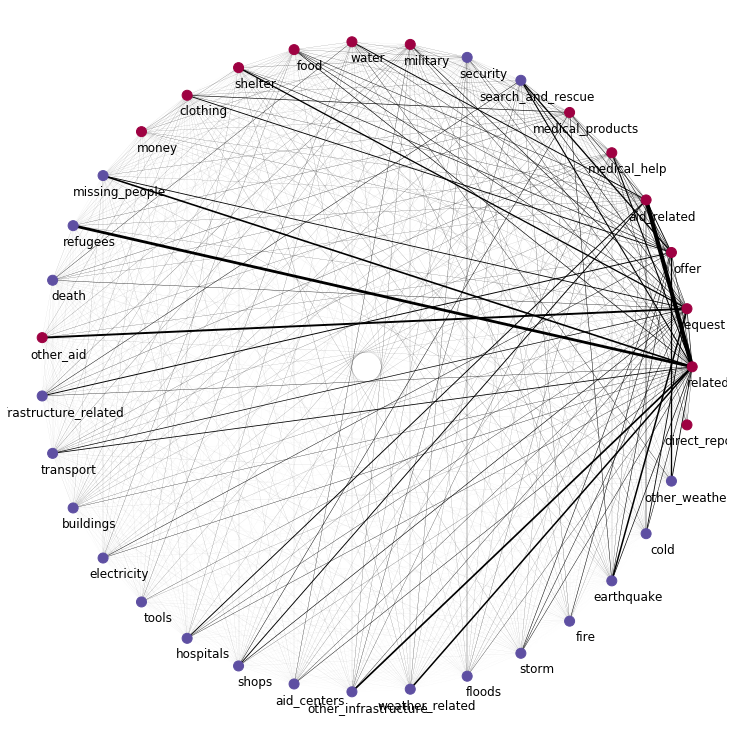

In [74]:
plt.figure(figsize=(10, 10))

G = clusterer.graph_
pos_nodes = nx.circular_layout(G)

nx.draw(
    G,
    pos=pos_nodes,
    labels=names_dict,
    with_labels=False,
    width=[10 * x / Y_train.shape[0] for x in clusterer.weights_['weight']],
    node_color=[membership_vector[i] for i in range(Y_train.shape[1])],
    cmap=plt.cm.Spectral,
    node_size=100,
    font_size=14
)

pos_attrs = {}
for node, coords in pos_nodes.items():
    pos_attrs[node] = (coords[0] + 0.05, coords[1] - 0.05)

nx.draw_networkx_labels(G, pos_attrs, labels=names_dict)
plt.show()

**Labels clustering**

In [221]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from MulticoreTSNE import MulticoreTSNE as TSNE
from umap import UMAP

In [222]:
pt = PowerTransformer()
Y_train_scaled = pt.fit_transform(Y_train)

In [223]:
pca = PCA()
Y_train_pca = pca.fit_transform(Y_train_scaled)
print(Y_train_pca.shape)
print(pca.explained_variance_ratio_.cumsum())

(20972, 35)
[0.12101119 0.19413618 0.24476989 0.29099811 0.32893352 0.36452261
 0.39799257 0.43099658 0.46288028 0.4937571  0.5230287  0.55129061
 0.57954042 0.607343   0.63455218 0.66113838 0.68769539 0.7135873
 0.73890807 0.76328001 0.78714699 0.81060193 0.83285488 0.85459842
 0.87490661 0.89480902 0.91319134 0.93070673 0.94755089 0.96407966
 0.98014623 0.98940206 0.99536876 0.99878225 1.        ]


K-Means

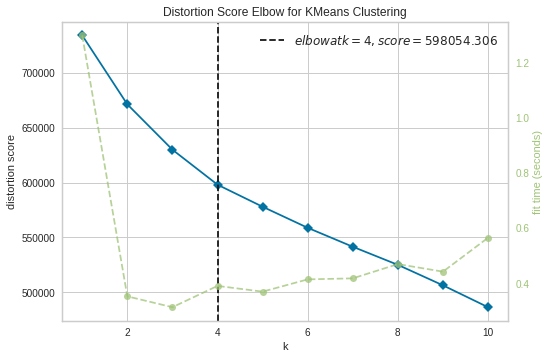

In [224]:
kmeans = KMeans(random_state=RANDOM_STATE, n_jobs=-1)
visualizer = KElbowVisualizer(kmeans, k=(1, 11))
visualizer.fit(Y_train_scaled)
visualizer.show()

In [225]:
best_n_clusters = 4

kmeans = KMeans(n_clusters=best_n_clusters, random_state=RANDOM_STATE, n_jobs=-1)
kmeans.fit(Y_train_scaled)

cluster_labels = kmeans.labels_
cluster_labels

array([3, 3, 3, ..., 2, 3, 3], dtype=int32)

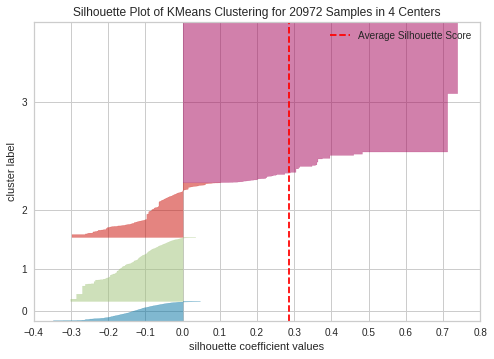

In [226]:
kmeans = KMeans(n_clusters=best_n_clusters, random_state=RANDOM_STATE, n_jobs=-1)

visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(Y_train_scaled)
visualizer.show() 

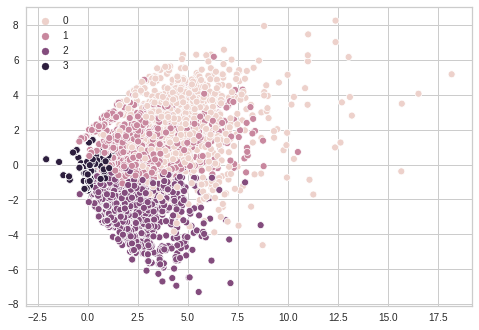

In [227]:
sns.scatterplot(Y_train_pca[:, 0], Y_train_pca[:, 1], hue=cluster_labels)

DBSCAN

In [228]:
from sklearn.cluster import DBSCAN

In [253]:
dbscan = DBSCAN(eps=0.1, min_samples=300, n_jobs=-1)
dbscan.fit(Y_train_scaled)

cluster_labels = dbscan.labels_
cluster_labels

array([-1,  0,  1, ..., -1,  0,  0])

In [254]:
np.unique(cluster_labels)

array([-1,  0,  1,  2,  3,  4])

In [255]:
len(cluster_labels)

20972

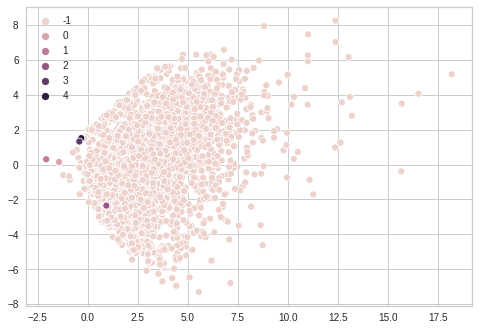

In [256]:
sns.scatterplot(Y_train_pca[:, 0], Y_train_pca[:, 1], hue=cluster_labels, legend='full')

Agglomerative Clustering

In [257]:
from sklearn.cluster import AgglomerativeClustering


In [258]:
agg_clust = AgglomerativeClustering(n_clusters=4)
agg_clust.fit(Y_train_scaled)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=4)

In [259]:
cluster_labels = agg_clust.labels_
cluster_labels

array([0, 3, 3, ..., 1, 3, 3])

In [260]:
np.unique(cluster_labels)

array([0, 1, 2, 3])

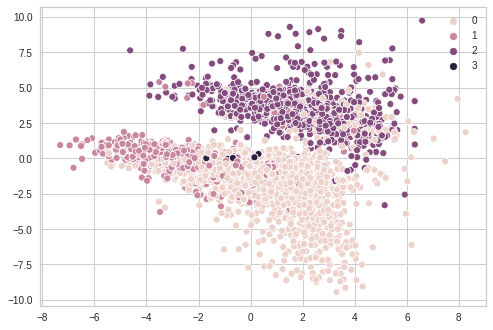

In [262]:
sns.scatterplot(Y_train_pca[:, 1], Y_train_pca[:, 2], hue=cluster_labels)

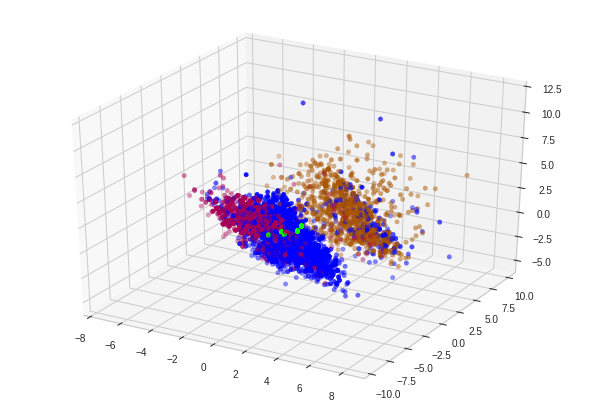

In [268]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(Y_train_pca[:, 1], Y_train_pca[:, 2], Y_train_pca[:, 3], c=cluster_labels, cmap='brg')

In [269]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [275]:
agg_clust = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
agg_clust.fit(Y_train_scaled)

In [278]:
cluster_labels = agg_clust.labels_
cluster_labels

array([20971, 20970, 20969, ...,     5,     2,     0])

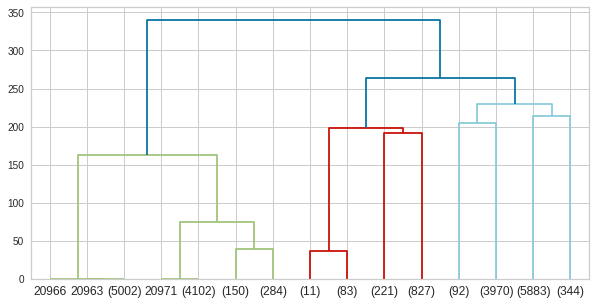

In [288]:
plt.figure(figsize=(10, 5))
plot_dendrogram(agg_clust, truncate_mode='level', p=3)